Download data and setup environment

In [ ]:
import cv2
import dlib
import gdown
import pickle
import warnings
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

import urllib.request

from sklearn import metrics


from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

###Getting the csv data loaded
!wget -q --show-progress -O ./ferdata.csv "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/fer2013_5.csv"

###Getting the Dlib Shape predictor!
!wget -q --show-progress -O ./shape_predictor_68_face_landmarks.dat "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat"

###Getting the Xpure loaded
!wget -q --show-progress -O ./pureX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/pureX.npy"

###Getting the Xdata loaded
!wget -q --show-progress -O ./dataX.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataX_edited.npy"

###Getting the Ydata loaded
!wget -q --show-progress -O ./dataY.npy "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/dataY.npy"

print ("Data Downloaded!")

./ferdata.csv       100%[===================>] 159.97M  90.7MB/s    in 1.8s    
./shape_predictor_6 100%[===================>]  95.08M  89.7MB/s    in 1.1s    
./pureX.npy         100%[===================>]  43.95M  40.8MB/s    in 1.1s    
./dataX.npy         100%[===================>] 347.59M  64.8MB/s    in 5.3s    
./dataY.npy         100%[===================>] 156.38K  --.-KB/s    in 0.003s  
Data Downloaded!


Load the dataset

In [ ]:
#Integer to Label Mapping
label_map = {0:"ANGRY",1:"HAPPY",2:"SAD",3:"SURPRISE",4:"NEUTRAL"}

#Load the data
df = pd.read_csv("./ferdata.csv")
df.head()

,emotion,pixels,Usage
0,0,215 216 215 215 215 216 216 216 214 178 81 30 ...,Training
1,4,244 244 244 244 243 244 242 190 132 93 81 73 7...,Training
2,4,255 255 255 255 255 255 255 255 255 255 255 25...,Training
3,4,38 56 60 52 58 65 53 44 35 48 59 60 36 30 21 3...,Training
4,4,77 40 27 21 22 25 20 31 27 17 27 42 47 55 51 4...,Training


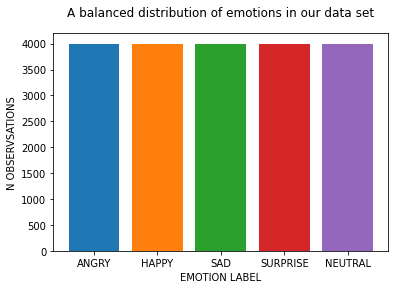

In [ ]:
# generate x labels for our plot
emotion_labels = [label_map[i] for i in label_map.keys()]

# generate counts for each emotion type
emotion_counts = [np.sum(df["emotion"] == i) for i in range(len(label_map))]

# generate a bar plot for our emotion labels that has different colors 
[plt.bar(x = emotion_labels[i], height = emotion_counts[i] ) for i in range(len(emotion_labels))] 

# make the plot interpretable with x and y labels + title
plt.xlabel('EMOTION LABEL')
plt.ylabel('N OBSERVSATIONS')
plt.title('A balanced distribution of emotions in our data set', y=1.05); 

Extraction of Facial Landmarks

In [ ]:
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):
  
  
  #:type image : cv2 object
  #:rtype landmarks : list of tuples where each tuple represents 
  #                  the x and y co-ordinates of facial keypoints
  
  #Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

  #Read Image using OpenCV
  #image = cv2.imread(image_path)
  #Detect the Faces within the image
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks

"""
Display image with its Facial Landmarks
"""
def plot_image_landmarks(image,face_landmarks):
  """
  :type image_path : str
  :type face_landmarks : list of tuples where each tuple represents 
                     the x and y co-ordinates of facial keypoints
  :rtype : None
  """
  radius = -2
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)
    
  plt.imshow(image_copy, interpolation='nearest', cmap='Greys_r')
  plt.xticks([]); plt.yticks([])
  plt.show()
  
 
'''
Converts pixels values to 2D-image. 
Displays the image and returns the cv2 image
object
'''
def get_pixels_image(img_pixels,plt_flag):
  """
  :type image_pixels : str
  :type plt_flag : boolean
  :rtype image : cv2 object
  """
  
  width = 48
  height = 48
  
  image = np.fromstring(img_pixels, dtype=np.uint8, sep=" ").reshape((height, width))
  
  if plt_flag:
      plt.imshow(image, interpolation='nearest', cmap="Greys_r")
      plt.xticks([]); plt.yticks([])
      plt.show()
      
      
  return image

Visualize Data Points

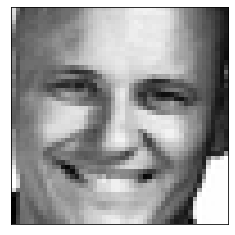

In [ ]:
# select random index 
i_index = np.random.randint(len(df))

# extract pixel values 
image_pixels = df['pixels'][i_index]        

# convert pixels to 2D Images
image = get_pixels_image(image_pixels, True)

Plot Facial Landmarks

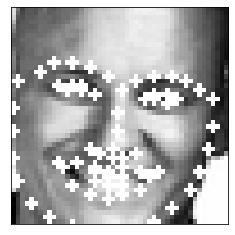

In [ ]:
#Extract the Facial Landmarks
image,facial_landmarks = get_landmarks(image)

#Display the Facial Landmarks on the Image
plot_image_landmarks(image,facial_landmarks)

Distance between Facial Landmarks

In [ ]:
def get_all_landmarks_euclid_dist(face_landmarks):
  
    e_dist = []
    for i, j in itertools.combinations(range(68), 2):
      e_dist.append(distance.euclidean(face_landmarks[i], face_landmarks[j]))
    
    return e_dist

Preprocess data to extract distance between all points

In [ ]:
def preprocess_data(df):
  
  X = []
  Y = []
  X_pixels = []
  
  n_pixels = 2304
  
  for index, row in (df.iterrows()):

      if index%1000 == 0:
        print (index, "Datapoints Processed")
        
      try:
          image = get_pixels_image(row['pixels'],0)
          X_pixels.append(image.ravel()) 
          image = cv2.GaussianBlur(image,(5,5),0)
         
          _,face_landmarks = get_landmarks(image)
          X.append(get_all_landmarks_euclid_dist(face_landmarks)) # Using our feature function!
          Y.append(row['emotion'])

      except Exception as e:
          print ("An error occured:",e)

  #Save the data 
  np.save("pureX", X_pixels)
  np.save("dataX", X)
  np.save("dataY", Y)
  
  return np.array(X_pixels),np.array(X),np.array(Y) 

Load Saved Data

In [ ]:
preload = True 

if preload: 

  # load outputs saved in this folder after running preprocess_data() 
  dataX = np.load('./dataX.npy')
  dataY = np.load('./dataY.npy', allow_pickle=True)
  
else: 
  
  # this takes 15-20 minutes to run, but someone has already run it and saved the ouputs in this folder
  pureX, dataX, dataY = preprocess_data(df)

Split the Data

In [ ]:
#Split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.1, random_state=42,stratify =dataY)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.493

Standardize the data

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(18000, 2278)

Dimensionality Reduction

In [ ]:
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test= pca.transform(X_test)

In [ ]:
X_train.shape

(18000, 20)

Train and evaluate model

In [ ]:
#######Train the model##################
knn = KNeighborsClassifier(n_neighbors=10)
print ("Training the knn model")
knn.fit(X_train, y_train)

#######Evaluate the model##################
#This cell will take longer to run(5-10mins)
print ("Predict for KNN Model")
y_predknn = knn.predict(X_test)
print ("Prediction Completed")
print ("Test Accuracy(KNN):",metrics.accuracy_score(y_test, y_predknn))

#-----------------DecisionTreeClassifier--------------#
#######Train the model##################
dt = DecisionTreeClassifier(max_depth=20)
print ("Training the Decision Tree model")
dt.fit(X_train, y_train)
print ("Completed Decision Tree Training")

#######Evaluate the model##################

print ("Predict for Decision Tree Model")
y_preddt = dt.predict(X_test)
print ("Test Accuracy(DT):",metrics.accuracy_score(y_test, y_preddt))

#-----------------Logistic Regression--------------#
#######Train the model##################
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial')
print ("Training the Logistic Regression model")
lr.fit(X_train, y_train)
print ("Completed LR Training")

#######Evaluate the model##################
#This cell will take longer to run(5-10mins)
print ("Predict for LR Model")
y_predlr = lr.predict(X_test)
print ("Test Accuracy(LR):",metrics.accuracy_score(y_test, y_predlr))

Plot the confusion matrix

In [ ]:
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

In [ ]:
plot_confusion_matrix(y_test,y_predlr)

Traning Model

In [ ]:
X = np.load('pureX.npy')
Y = np.load('dataY.npy')

In [ ]:
#Split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42,stratify =Y)


#Standardize the Data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#PCA #Returns 264 features out of 2304
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test= pca.transform(X_test)


# student code may look something like...

#######Train the model##################
knn = KNeighborsClassifier(n_neighbors=10)
print ("Training the knn model")
knn.fit(X_train, y_train)

#######Evaluate the model##################
# they might use accuracy_score
#This cell will take longer to run(5-10mins)!
print ("Predict for KNN Model")
y_predknn = knn.predict(X_test)
print ("Prediction Completed")
print ("Test Accuracy(KNN):",metrics.accuracy_score(y_test, y_predknn))



#-----------------DecisionTreeClassifier--------------#
#######Train the model##################
dt = DecisionTreeClassifier(max_depth=20)
print ("Training the Decision Tree model")
dt.fit(X_train, y_train)
print ("Completed Decision Tree Training")

#######Evaluate the model##################

print ("Predict for Decision Tree Model")
y_preddt = dt.predict(X_test)
print ("Test Accuracy(DT):",metrics.accuracy_score(y_test, y_preddt))


#-----------------Logistic Regression--------------#
#######Train the model##################
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial')
print ("Training the Logistic Regression model")
lr.fit(X_train, y_train)
print ("Completed LR Training")

#######Evaluate the model##################
# they might use accuracy_score
#This cell will take longer to run(5-10mins)!
print ("Predict for LR Model")
y_predlr = lr.predict(X_test)
print ("Test Accuracy(LR):",metrics.accuracy_score(y_test, y_predlr))

In [ ]:
from joblib import dump
dump(dt, "emo-detection-model.joblib") 

Finish a low accuracy model

In [ ]:
# extract images as vectors, convert from strings to ints -- this is called a "list comprehension" 
x_image = np.array( [np.fromstring(df['pixels'][i], dtype=np.uint8, sep=" ") for i in range(len(df))] ) 

# extract labels in the same way--through a list comprehension
y_image = np.array( [df['emotion'][i] for i in range(len(df)) ])

# generate train-test (90/10) splits
X_train, X_test, y_train, y_test = train_test_split(x_image, y_image, test_size=0.1,random_state=42)

# define the model
knn = KNeighborsClassifier(n_neighbors=10)

# train 
print ("training knn model ...")
knn.fit(X_train, y_train)

# test
print ("Predict for KNN Model")
y_pred_knn = knn.predict(X_test)

# display results
print ("KNN Test Accuracy on raw image inputs:", metrics.accuracy_score(y_test, y_pred_knn))